In [2]:
import re
import pprint

import hashlib
import json
import numpy as np
import pandas as pd

import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from datasets import Dataset 
from ragas.metrics import faithfulness, context_utilization
from ragas import evaluate

In [3]:
def load_auto_grade_results(filename, name, verbose=False):
    """Load results."""
    dataset = {}
    
    with open(filename, 'r') as f:
        for data in json.load(f):
            question = data['question']
            context_type = ['no_context','relevant','vague','irrelevant']
            context_encoder = {'no_context':0,'relevant':1,'vague':2,'irrelevant':3}
            for context in context_type:
                id = data['id']
                result = data[context]
                context_encoding = context_encoder[context]*10000
                id += context_encoding
                id = str(id)
                dataset[id] = {
                    'id': id,
                    'displayed_text': '',
                    # 'grade': result['grade'],
                    # 'content': result['content'],
                    'calculation_error': '',
                    'correctness_score': result['rationale'].get('matching_ground_truth') \
                                    or result['rationale'].get('matching_to_ground_truth') \
                                    or result['rationale'].get('match_to_ground_truth') \
                                    or result['rationale'].get('match_with_ground_truth') \
                                    or result['rationale'].get('matching') \
                                        if type(result['rationale']) == dict else 5,
                    'logic_score': result['rationale'].get('logic_and_reasoning') \
                                    or result['rationale'].get('logic') \
                                    or result['rationale'].get('logic_reasoning') \
                                        if type(result['rationale']) == dict else 5,
                    'truthfulness_score': result['rationale'].get('potential_hallucinations') \
                                    or result['rationale'].get('hallucinations') \
                                    or result['rationale'].get('potential_hallucinations') \
                                        if type(result['rationale']) == dict else 5,
                    'confidence_score': '',
                    'info':'',
                    'difficulty': int(id[0]),
                    'originality': int(id[1]),  # 0=copied, 1=paraphrased, 2=original
                    'context': int(id[2]),  # 0=no, 1=relevant, 2=vague, 3.irrelevant
                    'author': int(id[3]),  
                    'question_id': id[-4:],
                }
    dataset = pd.DataFrame(dataset).T.set_index('id')
    dataset['grader'] = name
    return dataset

def extract_score(s):
    """Extract score from dictionary."""
    assert len(s) <= 1
    if 'scale_1' in s:
        return int(s['scale_1'])
    elif 'scale_2' in s:
        return int(s['scale_2'])
    elif 'scale_3' in s:
        return int(s['scale_3'])
    elif 'scale_4' in s:
        return int(s['scale_4'])
    elif 'scale_5' in s:
        return int(s['scale_5'])
    
    return np.nan


def load_results(filename, name, verbose=False):
    """Load results."""
    data = {}
    
    with open(filename, 'r') as f:
        for line in f:
            v = json.loads(line)

            if len(v['id']) > len('2000000'):
                if verbose:
                    print(v)
                continue

            h = hashlib.md5(v['displayed_text'].encode('utf-8')).hexdigest()
            data[v['id']] = {
                'id': v['id'],
                'displayed_text': ' '.join(v['displayed_text'][:50].split()),
                #'span_annotations': v['span_annotations'],
                #'behavioral_data': v['behavioral_data'],

                'calculation_error': 1 if 'Calculation Error' in v['label_annotations'].get('Problems', '') else 0,

                'correctness_score': extract_score(v['label_annotations'].get('conclusion_Score', {})),
                'logic_score': extract_score(v['label_annotations'].get('logic_Score', {})),
                'truthfulness_score': extract_score(v['label_annotations'].get('truthfulness_Score', {})),

                'confidence_score': extract_score(v['label_annotations'].get('Confidence_Score', {})),

                'info': v['label_annotations'].get('textbox_input', {}).get('Descriptive grade', '') + \
                        ', ' + v['label_annotations'].get('textbox_input', {}).get('Comments', ''),
                'difficulty': int(v['id'][0]),  # 1=easy, 2=medium, 3=hard
                'originality': int(v['id'][1]),  # 0=copied, 1=paraphrased, 2=original
                'context': int(v['id'][2]),  # 0=no, 1=relevant, 2=vague, 3.irrelevant
                'author': int(v['id'][3]),  # 0=no, 1=relevant, 2=vague, 3.irrelevant
                'question_id': v['id'][-4:],
            }
    
    data = pd.DataFrame(data).T.set_index('id').sort_values(['question_id', 'context'])
    data['grader'] = name

    return data

def standardize_score(data,grader):
    df = data[data['grader'] == grader]
    # standardize score to 0-1
    df['correctness_score_n'] = (df['correctness_score'] - df['correctness_score'].mean()) / df['correctness_score'].std(ddof=0)
    df['logic_score_n'] = (df['logic_score'] - df['logic_score'].mean()) / df['logic_score'].std(ddof=0)
    df['truthfulness_score_n'] = (df['truthfulness_score'] - df['truthfulness_score'].mean()) / df['truthfulness_score'].std(ddof=0)
    return df



In [4]:
def load_prompt_results(file_path):
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Check if the required columns are in the DataFrame
    required_columns = ['id', 'question', 'generated_answer', 'ground_truth']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"The CSV file must contain the following columns: {', '.join(required_columns)}")

    # Read the JSON file for the mapping answers
    mapping_answer = read_json_from_file("Raw_Generated_answer_bank.json")

    # Prepare the dataset for each context
    for context_label in ['no_context', 'irrelevant', 'vague', 'relevant']:
        dataset_for_similarity = prepare_dataset_for_similarity(df, mapping_answer, context_label)
        print(len(dataset_for_similarity))
        # Call the calculate_similarity_score function to get the faithfulness and utilization scores
        score = calculate_similarity_score(dataset_for_similarity)
        print(score)
        
        # Add the scores to the DataFrame for the current context
        df[f'faithfulness_{context_label}'] = score['faithfulness']
        df[f'utilization_{context_label}'] = score['context_utilization']
        print("Checkpoint")
    
    # Return the updated DataFrame
    return df

def prepare_dataset_for_similarity(df, mapping_answer, context_label):
    # Convert mapping_answer into a dictionary for quick lookup by question
    question_to_answer = {item['question']: item for item in mapping_answer}
    
    # List to store the prepared dataset
    similarity_dataset = []
    
    # Iterate through the DataFrame
    for idx, row in df.iterrows():
        question = row['question'].strip()
        generated_answer = row['generated_answer'].strip()
        # Find the corresponding question in the mapping_answer
        if question in question_to_answer.keys():
            context_data = question_to_answer[question]
            # Prepare the context for the current label from the mapping_answer
            context = context_data.get(context_label, '')
            # Prepare the entry in the required format
            similarity_dataset.append({
                'question': [question],
                'answer': [generated_answer],
                'contexts': [[context]]  # Each context is a list
            })
        else:
            # Find the corresponding question in the mapping_answer
            for answer_question in question_to_answer.keys():
                # Compare the first 100 characters (being generous in matching)
                if question[:100] == answer_question[:100]:
                    context_data = question_to_answer[answer_question]
                    # Prepare the context for the current label from the mapping_answer
                    context = context_data.get(context_label, '')
                    # Prepare the entry in the required format
                    similarity_dataset.append({
                        'question': [question],
                        'answer': [generated_answer],
                        'contexts': [[context]]  # Each context is a list
                    })
                    break  # Stop after finding the first match
        
    return similarity_dataset

def calculate_similarity_score(dataset_list):
    # Convert the dataset to the required format using Dataset.from_dict
    results={'faithfulness': [],'context_utilization':[]}
    for dataset in dataset_list:
        dataset = Dataset.from_dict(dataset)
    
        # Perform evaluation and calculate similarity scores
        score = evaluate(dataset, metrics=[faithfulness, context_utilization])
        results['faithfulness'].append(score['faithfulness'])
        results['context_utilization'].append(score['context_utilization'])
        # Return the faithfulness and context utilization scores
    return results

def read_json_from_file(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data

In [5]:
# load
df = pd.concat([
    load_results('raw_data/abram.jsonl', name='abram'),
    load_results('raw_data/haoran.jsonl', name='haoran'),
    load_results('raw_data/louis.jsonl', name='louis'),
    load_results('raw_data/mikelixiang.jsonl', name='mikeli'),
    load_results('raw_data/Ryan_{{HYr}}.jsonl', name='ryan'),
    load_results('raw_data/ziwei.jsonl', name='ziwei')
])

standardized_df = pd.concat([
    standardize_score(df,'abram'),
    standardize_score(df,'haoran'),
    standardize_score(df,'louis'),
    standardize_score(df,'mikeli'),
    standardize_score(df,'ryan'),
    standardize_score(df,'ziwei'),
    # df[df['grader']=='autograde']
])
standardized_df

/var/folders/y0/5n71953n2_76_0v3gh0g_rxr0000gn/T/ipykernel_13038/292728351.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correctness_score_n'] = (df['correctness_score'] - df['correctness_score'].mean()) / df['correctness_score'].std(ddof=0)
/var/folders/y0/5n71953n2_76_0v3gh0g_rxr0000gn/T/ipykernel_13038/292728351.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['logic_score_n'] = (df['logic_score'] - df['logic_score'].mean()) / df['logic_score'].std(ddof=0)
/var/folders/y0/5n71953n2_76

,displayed_text,calculation_error,correctness_score,logic_score,truthfulness_score,confidence_score,info,difficulty,originality,context,author,question_id,grader,correctness_score_n,logic_score_n,truthfulness_score_n
id,,,,,,,,,,,,,,,,
2000000,Question:Suppose a system of two qubits is in ...,0,4,2,3,5,"While the firnal result is correct, the logic ...",2,0,0,0,0000,abram,-0.00935,-2.331434,-1.010572
2010000,Question:Suppose a system of two qubits is in ...,1,4,2,2,5,"Good final answer, many logic mistakes between,",2,0,1,0,0000,abram,-0.00935,-2.331434,-1.822093
2020000,Question:Suppose a system of two qubits is in ...,0,4,4,3,5,"Intermediate equation wrong,",2,0,2,0,0000,abram,-0.00935,-0.408602,-1.010572
2030000,Question:Suppose a system of two qubits is in ...,1,5,5,4,5,typo (hallucination) in the equation - but the...,2,0,3,0,0000,abram,0.73864,0.552814,-0.199052
2100001,Question:A system of two qubits is in a state(...,0,5,5,5,5,"Better than the ground truth,",2,1,0,0,0001,abram,0.73864,0.552814,0.612468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035004,Question:How does the principle of conservatio...,0,5,5,5,5,"A, The generated answer correctly explains the...",1,0,3,5,5004,ziwei,0.657414,0.54886,0.485194
3005005,Question:What are the implications of the unce...,0,5,5,5,4,"A, The generated answer provides an excellent ...",3,0,0,5,5005,ziwei,0.657414,0.54886,0.485194
3015005,Question:What are the implications of the unce...,0,5,5,5,5,"A, The generated answer correctly elucidates v...",3,0,1,5,5005,ziwei,0.657414,0.54886,0.485194


In [6]:
df_2 = load_prompt_results('Generated_answer_bank_v2.csv')
df_2.to_csv("score.csv", index=False)

160


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
def check_and_recompute_faithfulness_scores(df_2, mapping_answer):
    # Columns to check for faithfulness scores
    faithfulness_columns = [col for col in df_2.columns if 'faithfulness_' in col]
    for col in faithfulness_columns:
        for idx, row in df_2.iterrows():
            score = row[col]
            
            # Check if the score is not a valid number between 0 and 1
            if pd.isna(score) or not (0 <= score <= 1):
                print(f"Invalid faithfulness score detected in row {idx}, column {col}. Recomputing...")
                
                # Recompute the faithfulness score for this entry
                question = row['question']
                generated_answer = row['generated_answer']
                context_label = col.split('faithfulness_')[-1]  # Get the context from the column name

                # Prepare the dataset for recomputation
                dataset_for_similarity = prepare_dataset_for_similarity(df_2.iloc[[idx]], mapping_answer, context_label)
                
                # Recompute the score
                new_score = calculate_similarity_score(dataset_for_similarity)
                print(new_score)
                
                # Update the DataFrame with the recomputed score
                df_2.at[idx, col] = new_score['faithfulness'][0]  # Replace with the new computed value

    return df_2
# Assuming df_2 and mapping_answer are already defined and loaded
mapping_answer = read_json_from_file("Raw_Generated_answer_bank.json")
df_2 = check_and_recompute_faithfulness_scores(df_2, mapping_answer)


NameError: name 'df_2' is not defined

In [ ]:
df_2.to_csv("score_complete.csv", index=False)

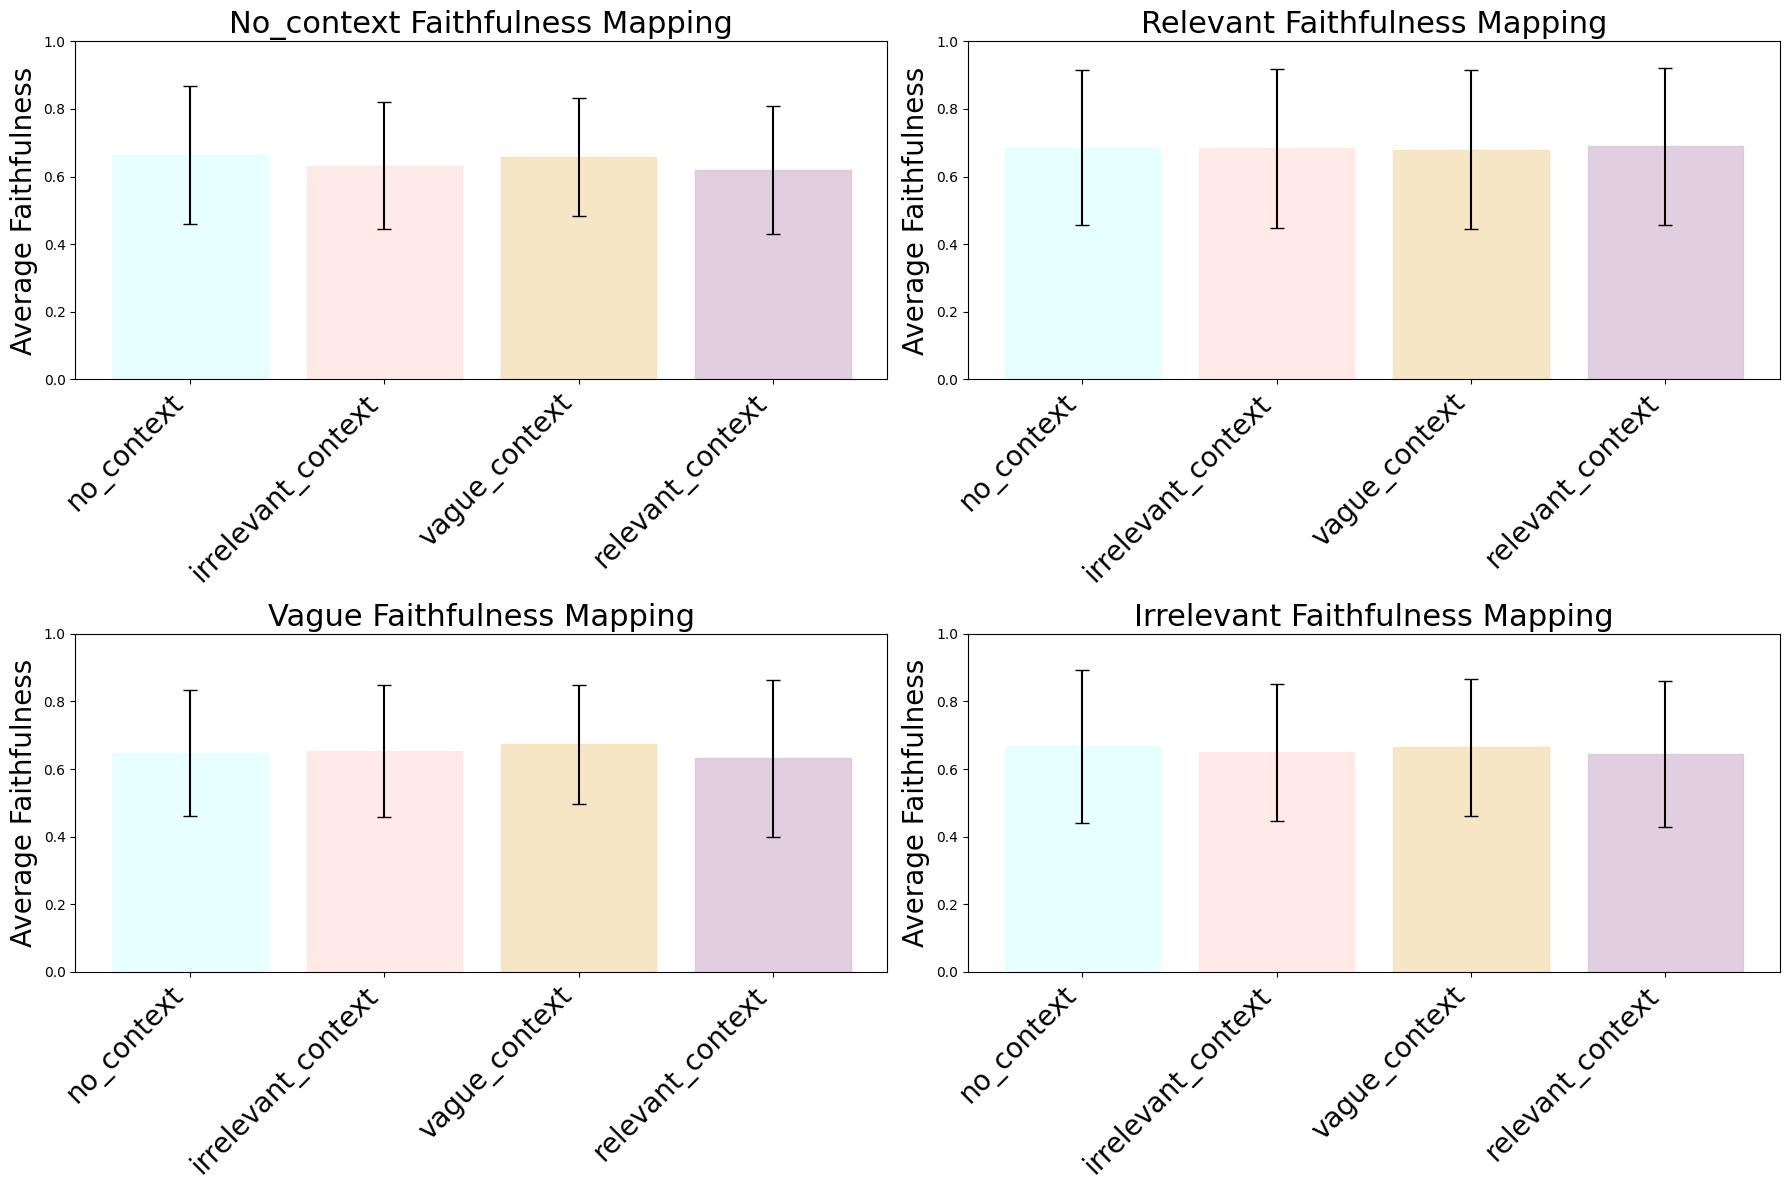

In [8]:
import matplotlib.pyplot as plt
df_2=pd.read_csv("score_complete.csv")
def separate_and_plot_faithfulness(df_2):
    """
    Separates df_2 into four categories based on the context level (0 = no context, 1 = relevant, 2 = vague, 3 = irrelevant),
    computes the average faithfulness for each context, plots the results in a panel of four bar plots with error bars,
    and applies customized styling.
    
    Args:
        df_2 (pd.DataFrame): The DataFrame containing the faithfulness scores and ids.
    """
    # Convert the 'id' column to string to ensure subscripting works
    df_2['id'] = df_2['id'].astype(str)
    
    # Define the order of context types and their custom labels
    context_labels = ['no_context', 'irrelevant_context', 'vague_context', 'relevant_context']
    
    # Define colors for each context type
    context_colors = {
        'no_context': '#E0FFFF',       # Light Steel Blue
        'irrelevant_context': '#FFE4E1', # Light Gray
        'vague_context': '#F5DEB3',     # Thistle
        'relevant_context': '#D8BFD8'   # Lavender
    }
    
    # Separate the DataFrame based on context level from the 'id' column
    categories = {
        'no_context': df_2[df_2['id'].apply(lambda x: int(x[2]) == 0)],
        'relevant': df_2[df_2['id'].apply(lambda x: int(x[2]) == 1)],
        'vague': df_2[df_2['id'].apply(lambda x: int(x[2]) == 2)],
        'irrelevant': df_2[df_2['id'].apply(lambda x: int(x[2]) == 3)]
    }

    # Set up the subplot grid (2x2)
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))  # Adjust size as needed
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust space between plots

    # Iterate through the categories and plot average faithfulness for each context
    for i, (context_level, df_category) in enumerate(categories.items()):
        averages = []
        errors = []
        
        for context in context_labels:
            if context=="no_context":
                col_name = f'faithfulness_{context}'  # Use base context name for columns
            else:
                col_name = f'faithfulness_{context.split("_")[0]}'  # Use base context name for columns
            if col_name in df_category.columns:
                averages.append(df_category[col_name].mean())
                errors.append(df_category[col_name].std(ddof=0))  # Standard deviation for error bars (population std)
            else:
                averages.append(0)  # If the column doesn't exist, append 0
                errors.append(0)    # No error if no data
        
        # Determine the position in the 2x2 grid
        ax = axs[i // 2, i % 2]
        
        # Plot the average faithfulness with error bars for this context level
        bars = ax.bar(context_labels, averages, yerr=errors, alpha=0.75, edgecolor='black', capsize=5)

        # Set the color for each bar
        for bar, context in zip(bars, context_labels):
            bar.set_color(context_colors[context])
        
        # Set labels and custom labels for the x-axis
        ax.set_ylabel('Average Faithfulness', fontsize=20)
        ax.set_title(f"{context_level.capitalize()} Faithfulness Mapping", fontsize=22)
        ax.set_xticks(range(len(context_labels)))
        ax.set_xticklabels(context_labels, rotation=45, ha="right", fontsize=20)  # Adjust label rotation and alignment
        ax.set_ylim(0, 1)  # Faithfulness scores should be between 0 and 1
    
    # Display the plot with tight layout
    plt.tight_layout()  # Adjust layout to make sure everything fits without overlap
    plt.show()

# Example usage
separate_and_plot_faithfulness(df_2)
